In [ ]:
#importer les bibliotheques/modules/packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, LeakyReLU

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_excel(r"data/ALG_data.xlsx", parse_dates=['Date'], index_col='Date')
print(df.head()) #afficher un aperçu des données
print('\n')

#sélection des variables d'entrée
features = ['T', 'Po', 'U', 'Ff', 'Td']
df = df[features]

#normalisation des données
colonnes_norm = ['T', 'Po', 'U', 'Ff', 'Td']
scaler = MinMaxScaler(feature_range=(0,1)) #normaliser entre 0 et 1
df[colonnes_norm] = scaler.fit_transform(df[colonnes_norm])
print("Données normalisées")
print(df.head())

print('\n')

#convertir en numpy array après normalisation
df_scaled = df[colonnes_norm].values 
df.head()

#définition de la fenêtre temporelle (6 jours pour prédire le 7e)
time_steps = 6  
X, y = [], []

for i in range(len(df_scaled) - time_steps):
    X.append(df_scaled[i:i+time_steps])
    y.append(df_scaled[i+time_steps, 0])

X, y = np.array(X), np.array(y)

dates = df.index[time_steps:time_steps+len(y)] 
n_samples = len(X)
test_size = int(n_samples * 0.1)  # 10%
val_size = int(n_samples * 0.1)   # 10%

train_idx_end = n_samples - test_size - val_size
val_idx_end = train_idx_end + val_size

X_train, y_train = X[:train_idx_end], y[:train_idx_end] #80%
X_valid, y_valid = X[train_idx_end:val_idx_end], y[train_idx_end:val_idx_end] #10%
X_test, y_test = X[val_idx_end:], y[val_idx_end:] #10%

dates_train = dates[:train_idx_end]
dates_valid = dates[train_idx_end:val_idx_end]
dates_test = dates[val_idx_end:]

assert len(dates_train) == len(y_train) == X_train.shape[0]
assert len(dates_valid) == len(y_valid) == X_valid.shape[0]
assert len(dates_test) == len(y_test) == X_test.shape[0]

print(f"Train : {len(X_train)} échantillons ({len(X_train)/len(X)*100:.1f}%)")
print(f"Valid : {len(X_valid)} échantillons ({len(X_valid)/len(X)*100:.1f}%)")
print(f"Test  : {len(X_test)} échantillons ({len(X_test)/len(X)*100:.1f}%)")

                  T        Po       U     Ff       Td
Date                                                 
2016-01-01  12.1750  766.9500  83.375  1.250   8.9375
2016-01-02  14.3875  764.7875  76.000  4.000   9.6000
2016-01-03  15.9125  762.5375  87.875  2.125  13.8625
2016-01-04  20.1500  756.4625  61.625  6.000  12.4375
2016-01-05  17.4500  753.9875  72.250  4.875  12.2500


Données normalisées
                   T        Po         U        Ff        Td
Date                                                        
2016-01-01  0.198630  0.674409  0.825040  0.098039  0.451977
2016-01-02  0.262437  0.600000  0.730337  0.313725  0.475011
2016-01-03  0.306417  0.522581  0.882825  0.166667  0.623207
2016-01-04  0.428623  0.313548  0.545746  0.470588  0.573664
2016-01-05  0.350757  0.228387  0.682183  0.382353  0.567145


Train : 2406 échantillons (80.0%)
Valid : 300 échantillons (10.0%)
Test  : 300 échantillons (10.0%)


**Construction du modèle CNN-LSTM**

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)
# Configurations à tester
architectures = [
    {'conv_filters': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.3},
    {'conv_filters': 128, 'lstm_units': 256, 'dense_units': 128, 'dropout': 0.4},
    {'conv_filters': 256, 'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2},
    {'conv_filters': 32, 'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2},
    {'conv_filters': 16, 'lstm_units': 32, 'dense_units': 16, 'dropout': 0.3, 'kernel_size': 3},
    {'conv_filters': 64, 'lstm_units': 32, 'dense_units': 16, 'dropout': 0.4, 'pooling': 'max'},
    {'conv_filters': [64, 128], 'lstm_units': 256, 'dense_units': 128, 'dropout': 0.5},  # 2 couches CNN
    {'conv_filters': 128, 'lstm_units': [128, 64], 'dense_units': 64, 'dropout': 0.3},  # 2 couches LSTM
    {'conv_filters': 64, 'lstm_units': 128, 'dense_units': [64, 32], 'dropout': 0.4},    # 2 couches Dense
    {'conv_filters': [32, 64, 128], 'lstm_units': 64, 'dense_units': 32, 'dropout': 0.5},
    {'conv_filters': 32, 'lstm_units': 64, 'dense_units': 16, 'dropout': 0.2, 'kernel_size': 3}, # Architecture shallow (peu profonde)
    {'conv_filters': [64, 128, 256], 'lstm_units': [128, 64], 'dense_units': [64, 32], 'dropout': 0.5}, # Architecture profonde avec régularisation
    {'conv_filters': 256, 'lstm_units': 512, 'dense_units': 256, 'dropout': 0.4}, # Architecture large (plus de neurones)
    {'conv_filters': [32, 64], 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.3, 'kernel_size': 3, 'use_batchnorm': True},
    {'conv_filters': 64, 'lstm_units': [64, 32], 'gru_units': 32, 'dense_units': 16, 'dropout': 0.3}, # Stacked LSTM + GRU mix
    {'conv_filters': [64, 128], 'lstm_units': 64, 'dense_units': 32, 'dropout': 0.4, 'pooling': ['max', 'avg']}, # Double pooling
    {'conv_filters': [128, 64], 'lstm_units': [256, 128], 'dense_units': [64, 32], 'dropout': 0.3}, # Architecture asymétrique
    {'conv_filters': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.6, 'recurrent_dropout': 0.5}, # Très régularisée
    {'conv_filters': [64, 128], 'lstm_units': 128, 'dense_units': [64, 32], 'dropout': 0.3, 'use_skip': True},
    {'conv_filters': 16, 'lstm_units': 32, 'dense_units': 8, 'dropout': 0.2, 'kernel_size': 3} # Minimaliste
]

results = {}
for config in architectures:
    print(f"\nTesting architecture: {config}")
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    
    if isinstance(config['conv_filters'], list):
        for i, filters in enumerate(config['conv_filters']):
            x = Conv1D(filters, 5, padding='causal', activation='relu')(x)
            if x.shape[1] // 2 > 0: 
                x = MaxPooling1D(2)(x)
            x = BatchNormalization()(x)
    else:
        x = Conv1D(config['conv_filters'], 5, padding='causal', activation='relu')(x)
        if x.shape[1] // 2 > 0:
            x = MaxPooling1D(2)(x)
    
    if isinstance(config['lstm_units'], list):
        for units in config['lstm_units'][:-1]:
            x = LSTM(units, dropout=config['dropout'], return_sequences=True)(x)
        x = LSTM(config['lstm_units'][-1], dropout=config['dropout'])(x)
    else:
        x = LSTM(config['lstm_units'], dropout=config['dropout'])(x)
    
    if isinstance(config['dense_units'], list):
        for units in config['dense_units']:
            x = Dense(units, activation='swish')(x)
    else:
        x = Dense(config['dense_units'], activation='swish')(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(
                monitor='val_root_mean_squared_error',
                patience=25,
                restore_best_weights=True
            )
        ]
    )
    
    results[str(config)] = min(history.history['val_root_mean_squared_error'])
    
    best_rmse = min(history.history['val_root_mean_squared_error'])
    results[str(config)] = best_rmse
    print(f"RMSE validation: {best_rmse:.4f}")

# Affichage des résultats
print("\n Résultats comparatifs:")
for config, rmse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{config[:60]}... | RMSE: {rmse:.4f}")

best_config = min(results, key=results.get)
print(f"\n Meilleure architecture: {best_config} (RMSE: {results[best_config]:.4f})")


Testing architecture: {'conv_filters': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.3}
Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0437 - root_mean_squared_error: 0.1975 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.004

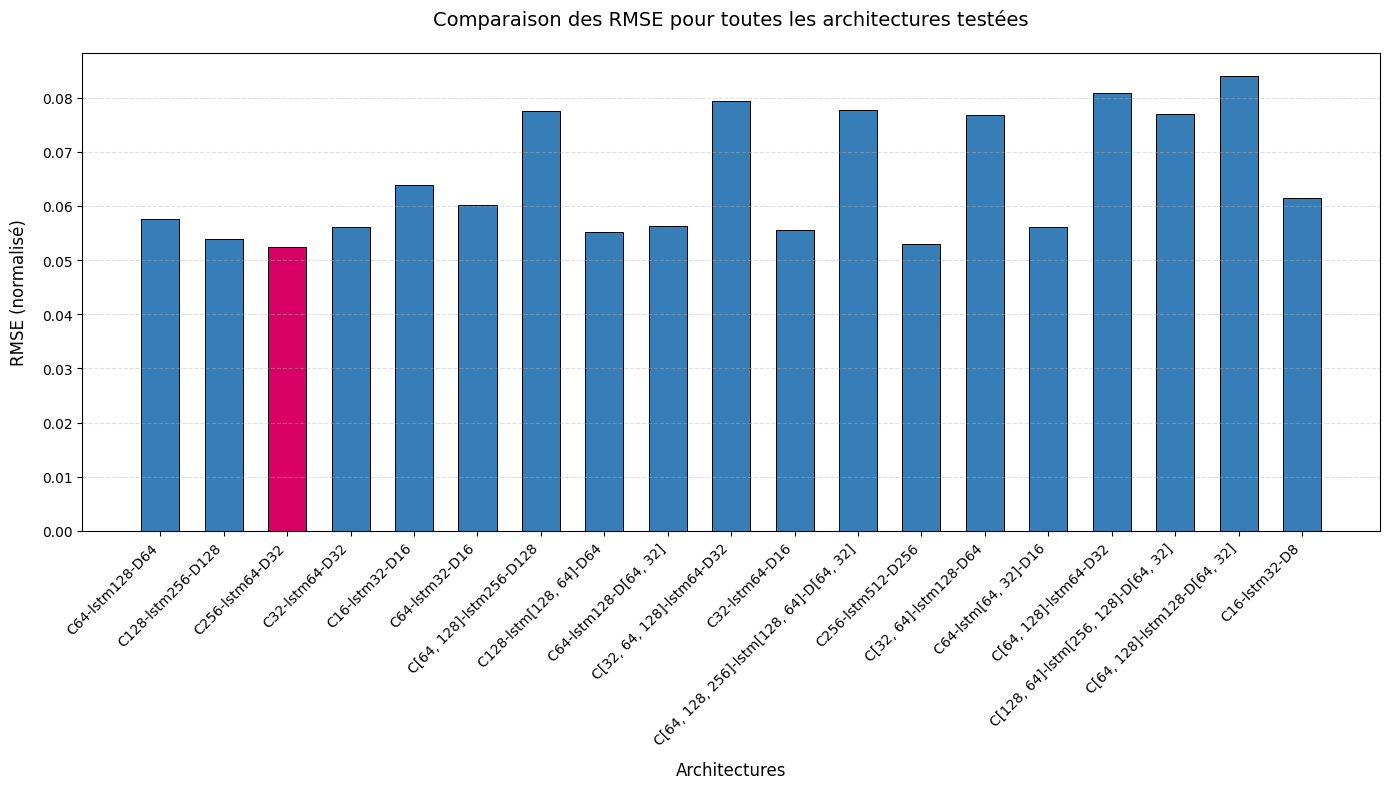

In [4]:
arch_names = [f"C{cfg['conv_filters']}-lstm{cfg['lstm_units']}-D{cfg['dense_units']}" for cfg in architectures]
rmse_values = list(results.values())
best_idx = np.argmin(rmse_values)

plt.figure(figsize=(14, 8))
colors = ['#D90166' if i == best_idx else '#377eb8' for i in range(len(arch_names))]
bars = plt.bar(arch_names, rmse_values, color=colors, edgecolor='black', linewidth=0.7, width=0.6)

plt.title('Comparaison des RMSE pour toutes les architectures testées', pad=20, fontsize=14)
plt.xlabel('Architectures', fontsize=12, labelpad=10)
plt.ylabel('RMSE (normalisé)', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

**Création du modèle final**

In [6]:
X_full = np.concatenate([X_train, X_valid])
y_full = np.concatenate([y_train, y_valid])

final_model = Sequential([
    Conv1D(256, 5, padding='causal', activation='relu', 
           input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    LSTM(64, dropout=0.2),
    Dense(32, activation='swish'),
    Dense(1)
])

# Compilation
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'RootMeanSquaredError'] 
)

final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 6, 256)         │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,945 (355.25 KB)

 Trainable params: 90,945 (355.25 KB)

 Non-trainable params: 0 (0.00 B)

**Entrainement du modèle**

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Callback 
checkpoint = ModelCheckpoint(
    'best_meteo_model.h5',
    monitor='val_root_mean_squared_error',
    save_best_only=True,
    mode='min'
)

# Entraînement final
history = final_model.fit(
    X_full, y_full,
    validation_data=(X_valid, y_valid), 
    epochs=200,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_root_mean_squared_error', patience=50, mode='min'),
        checkpoint
    ],
    verbose=1
)

Epoch 1/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RootMeanSquaredError: 0.0431 - loss: 0.0019 - mae: 0.0325 - val_RootMeanSquaredError: 0.0428 - val_loss: 0.0018 - val_mae: 0.0325
Epoch 2/200
 5/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - RootMeanSquaredError: 0.0463 - loss: 0.0021 - mae: 0.0343

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_root_mean_squared_error` which is not available. Available metrics are: RootMeanSquaredError,loss,mae,val_RootMeanSquaredError,val_loss,val_mae
  current = self.get_monitor_value(logs)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_root_mean_squared_error available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RootMeanSquaredError: 0.0427 - loss: 0.0018 - mae: 0.0324 - val_RootMeanSquaredError: 0.0450 - val_loss: 0.0020 - val_mae: 0.0340
Epoch 3/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - RootMeanSquaredError: 0.0437 - loss: 0.0019 - mae: 0.0333 - val_RootMeanSquaredError: 0.0468 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 4/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - RootMeanSquaredError: 0.0440 - loss: 0.0019 - mae: 0.0338 - val_RootMeanSquaredError: 0.0418 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 5/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - RootMeanSquaredError: 0.0431 - loss: 0.0019 - mae: 0.0324 - val_RootMeanSquaredError: 0.0424 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 6/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RootMeanSquaredError: 0.0431 - loss: 0.0019 - mae: 0.0325 - val_RootMeanSquaredError: 0.0428 - val_loss: 0.0018 - val_mae: 0.0324
Epoch 7/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - RootMeanSquaredError: 0.0426 - loss: 0

In [11]:
test_loss, test_mae, test_rmse = final_model.evaluate(X_test, y_test)
print(f"MAE: {test_mae}, RMSE: {test_rmse}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - RootMeanSquaredError: 0.0591 - loss: 0.0036 - mae: 0.0401
MAE: 0.04287565499544144, RMSE: 0.059321098029613495


In [17]:
# Prédictions
predictions = final_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [18]:
# Récupération des dernières valeurs des autres features
last_step_features = X_test[:, -1, 1:]  # Dernier pas de temps, autres colonnes que T

# Fusion avec les prédictions
predictions_expanded = np.column_stack([
    predictions.squeeze(),  # Température prédite
    last_step_features      # Autres features réelles
])

# Dénormalisation
predictions_real = scaler.inverse_transform(predictions_expanded)[:, 0]

# Pour y_test (même principe)
y_test_expanded = np.column_stack([
    y_test.squeeze(),
    last_step_features
])
y_test_real = scaler.inverse_transform(y_test_expanded)[:, 0]

# Vérification
print(f"Température réelle : min={y_test_real.min():.2f}, max={y_test_real.max():.2f}")
print(f"Température prédite : min={predictions_real.min():.2f}, max={predictions_real.max():.2f}")

Température réelle : min=8.44, max=39.96
Température prédite : min=7.85, max=32.25


In [19]:
from sklearn.metrics import mean_squared_error

y_val_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

# Calcul du RMSE
rmse_val = np.sqrt(mean_squared_error(y_valid, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

RMSE_V_dénormalisé = rmse_val * (y_valid.max() - y_valid.min())
RMSE_dénormalisé = best_rmse * (y_test_real.max() - y_test_real.min())

print(f"RMSE (Validation): {rmse_val:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")

print(f"RMSE (Validation) dénormalisé : {RMSE_V_dénormalisé:.2f}°C")
print(f"RMSE (Test) dénormalisé : {RMSE_dénormalisé:.2f}°C")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE (Validation): 0.0615
RMSE (Test): 0.0659
RMSE (Validation) dénormalisé : 0.05°C
RMSE (Test) dénormalisé : 1.94°C


**Graphe de comparaisons des températures réelles et prédites à Alger**

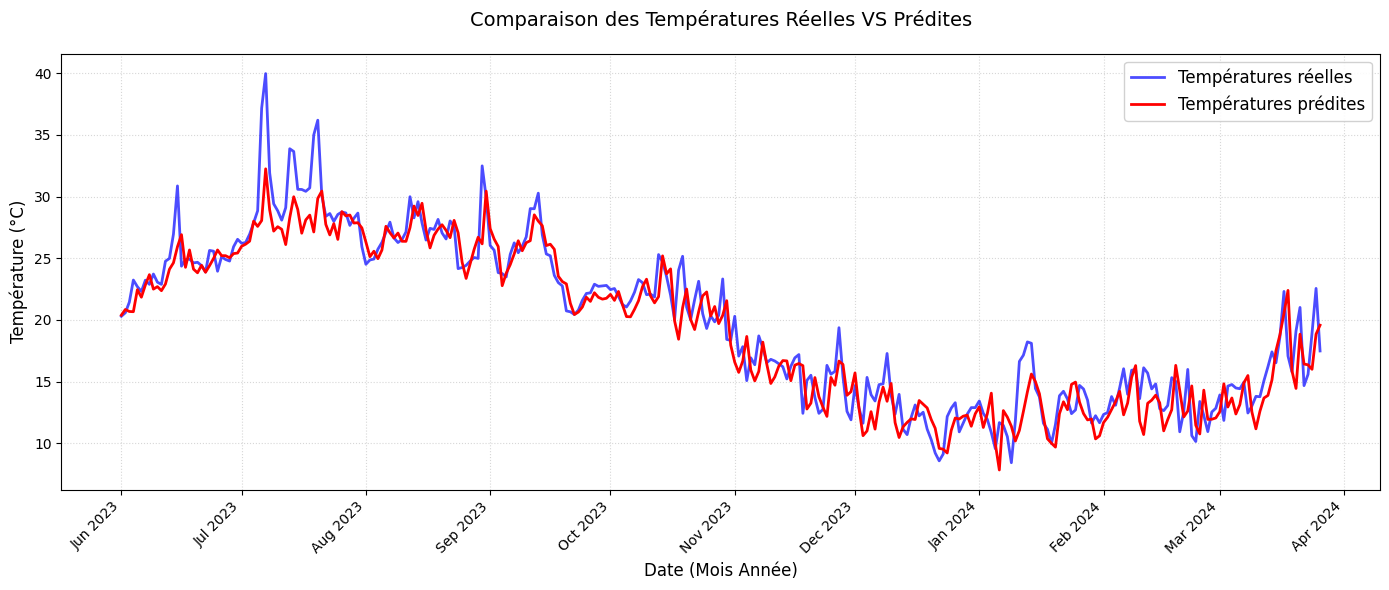

In [20]:
import matplotlib.dates as mdates
from datetime import datetime

dates = pd.date_range(start='2023-06-01', periods=len(y_test_real), freq='D') 

plt.figure(figsize=(14, 6))

mean_real = y_test_real.mean()
mean_pred = predictions_real.mean()

plt.plot(dates, y_test_real, 
         label='Températures réelles', 
         color='blue',
         alpha=0.7, 
         linewidth=2)

plt.plot(dates, predictions_real,
         label='Températures prédites',
         color='red',
         linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  


plt.title('Comparaison des Températures Réelles VS Prédites', pad=20, fontsize=14)
plt.xlabel('Date (Mois Année)', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.5)
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.show()

**Diagramme de dispersion**

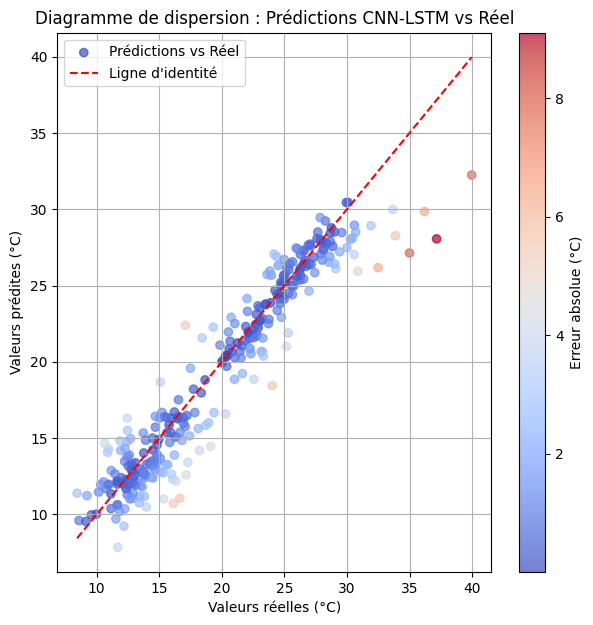

In [21]:
y_test_real_flat = y_test_real.flatten()
predictions_flat = predictions_real.flatten()

erreur_absolue = np.abs(y_test_real - predictions_real)

plt.figure(figsize=(7, 7))
scatter = plt.scatter(y_test_real_flat, predictions_flat,c=erreur_absolue, cmap='coolwarm', alpha=0.7, label="Prédictions vs Réel")

plt.plot([y_test_real_flat.min(), y_test_real_flat.max()], 
         [y_test_real_flat.min(), y_test_real_flat.max()], 
         color='red', linestyle='--', label="Ligne d'identité")

cbar = plt.colorbar(scatter)
cbar.set_label("Erreur absolue (°C)")

plt.xlabel("Valeurs réelles (°C)")
plt.ylabel("Valeurs prédites (°C)")
plt.title("Diagramme de dispersion : Prédictions CNN-LSTM vs Réel")
plt.legend()
plt.grid(True)

plt.show()

In [26]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Assurer que toutes les données sont 1D
y_test_real = np.ravel(y_test_real)  # Convertit (300,1) en (300,)
predictions_real = np.ravel(predictions_real)
y_test = np.ravel(y_test)  # Ajouté car visiblement présent dans votre code
y_test_pred = np.ravel(y_test_pred)  # Ajouté car visiblement présent dans votre code

results_df = pd.DataFrame({'Valeur_Réelle': y_test, 'Prédiction': y_test_pred}, index=dates_test)

# 2. Calcul des métriques de performance
metrics = {
    'RMSE': [np.sqrt(np.mean((y_test_real - predictions_real)**2))],
    'MAE': [np.mean(np.abs(y_test_real - predictions_real))],
    'Moyenne Réelle': [mean_real],
    'Moyenne Prédite': [mean_pred]
}
metrics_df = pd.DataFrame(metrics)

# 3. Export vers Excel avec plusieurs feuilles
with pd.ExcelWriter('resultats_temperature.xlsx', engine='openpyxl') as writer:
    # Feuille des résultats détaillés
    results_df.to_excel(writer, sheet_name='Résultats', index=False)
    
    # Feuille des métriques
    metrics_df.to_excel(writer, sheet_name='Métriques', index=False)
    

print("Export Excel terminé : resultats_temperature.xlsx")

Export Excel terminé : resultats_temperature.xlsx


In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Assurer que toutes les données sont 1D
y_test_real = np.ravel(y_test_real)
predictions_real = np.ravel(predictions_real)
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_test_pred)

results_df = pd.DataFrame({'Valeur_Réelle': y_test, 'Prédiction': y_test_pred, 'Valeur_Réelle_Dénorm': y_test_real, 'Prédiction_Dénorm': predictions_real}, index=dates_test)


# 4. Export vers Excel
with pd.ExcelWriter('resultats_temperature.xlsx', engine='openpyxl') as writer:
    # Feuille des résultats
    results_df.to_excel(writer, sheet_name='Résultats', index=False)
    
    
    # Formatage automatique des colonnes
    workbook = writer.book
    worksheet = writer.sheets['Résultats']
    
    # Largeur de colonne automatique
    for column in results_df:
        col_idx = results_df.columns.get_loc(column)
        max_len = max(results_df[column].astype(str).map(len).max(), len(column)) + 2
        worksheet.column_dimensions[chr(65 + col_idx)].width = max_len

print("Export Excel terminé : resultats_temperature.xlsx")

Export Excel terminé : resultats_temperature.xlsx
